# A tutorial for running a flood simulation

This tutorial is written as a Jupyter notebook and provides a step-by-step tutorial for setting up a flood model and plot its outputs. We will use the sample data included in the pypims package. The note book can be downloaded from

## Explaning the data

The first step is to list which data is included in the sample.

In [18]:
from pypims import IO
import os
from pypims.IO.demo_functions import get_sample_data
dem_file, demo_data = get_sample_data() # get the path of sample data
data_path = os.path.dirname(dem_file)
os.listdir(data_path)

['landcover.gz', 'DEM.gz', 'rain_mask.gz', 'rain_source.csv']

As we can see from the list, there are 4 files in the folder. The three files ended with '.gz' are raster files for the DEM, rainfall mask and land cover types. These files are gzip compressions of ArcGIS ASCII format. The other file named 'rain_source.csv' is the time series of the rainfall intensity. We will now load these files and explain what they are used for in the simulation.

The first file we will look at is 'DEM.gz'. It defines the topography on which the flood simulation is running. In the simulation, each single valid pixel in the DEM is a cell within the computational domain. We can use the 'Raster' and 'grid_show' model built in pypims to visualise it. As we can see from the figure, the DEM represents a catchment with a main channel and three tributaries.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='meter towards east', ylabel='meter towards north'>)

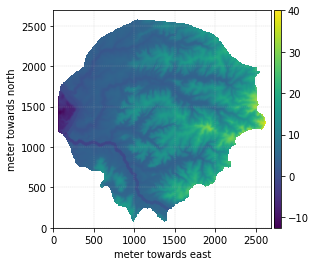

In [3]:
DEM = IO.Raster(os.path.join(data_path,'DEM.gz')) # load the file into a Raster object
IO.grid_show.mapshow(DEM) # plot the Raster object

The other file 'rain_mask' gives an index [0, 1, 2, ...] to every grid cell. These indices decide which time series data of the rainfall intensities will be used as the rainfall source term. As we can see from the figure, all the grid cells within the domain has an index of '0'.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='meter towards east', ylabel='meter towards north'>)

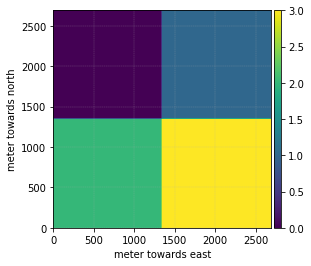

In [4]:
rain_mask = IO.Raster(os.path.join(data_path,'rain_mask.gz'))
IO.grid_show.mapshow(rain_mask)

We can use the pandas package to load 'rain_source.csv' and show its contents. The first column is the time stamps (in seconds). The following columns are the rainfall intensity values (in meter per second) for cells with rain mask index starting from 0. For instance, the second column is for cells with index 0, the third column is for cells with index 1 and so on. 

In [5]:
import pandas as pd
rain_source = pd.read_csv(os.path.join(data_path,'rain_source.csv'), header = None)
rain_source.head()

,0,1,2,3,4
0,0,0,0.000014,0,0.000001
1,360,0,0.000014,0,0.000001
2,720,0,0.000014,0,0.000001
3,1080,0,0.000014,0,0.000001
4,1440,0,0.000014,0,0.000001


The file 'landcover.gz' gives difference indices to each grid cell to label their land cover types. In our case, there are two land cover types labelled by '0' and '1'.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='meter towards east', ylabel='meter towards north'>)

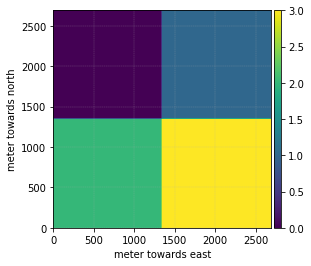

In [6]:
landcover = IO.Raster(os.path.join(data_path,'landcover.gz'))
IO.grid_show.mapshow(landcover)

## Generating the inputs and runing the simulation

We will now use the data we have just loaded to set up a flood model. In the first step, we need to initialise an InputHipims object with the DEM. We also want specify the directory where the simulation is run and the number of devices we want to use.

In [7]:
case_folder = os.path.join(os.getcwd(), 'hipims_case') # define a case folder in the current directory
case_input = IO.InputHipims(DEM, num_of_sections=1, case_folder=case_folder)

We can then put some water inthe catchment by setting an initial depth. In our case, the initial water depth is 0 m across the catchment.

In [8]:
case_input.set_initial_condition('h0', 0.0)

We can put some boundary conditions herein. We can assume that there is a 100 m3/s dicharge from the upstream of the river, and the downstream of the river is open. The locations of the boundaries can be defined by a box that encloses the boundary section. We simply need to define the coordinates of two opposite corners of the box, for instance, the upper left and bottom right coner points. 

In [9]:
import numpy as np
box_upstream = np.array([[88, 1163], # upper left
                         [176, 1061]]) # bottom right
box_downstream = np.array([[70, 1686], # upper left
                         [135, 1798]]) # bottom right
discharge_values = np.array([[0, 100], # first column: time - s; second colum: discharge - m3/s
                            [3600,100]])

We then use a list of dicts to put things together.

In [10]:
bound_list = [
            {'polyPoints': box_upstream,
             'type': 'open',
             'hU': discharge_values},
            {'polyPoints': box_downstream,
             'type': 'open',
             'h': np.array([[0, 0],
                            [3600,0]])}] # we fix the downstream depth as 0 m

Now we can set up the boundary conditions and check whether it has been set up correctly.

Flow series on boundary 1 is converted to velocities
Theta = 38.92degree


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Domain Map'}, xlabel='meter towards east', ylabel='meter towards north'>)

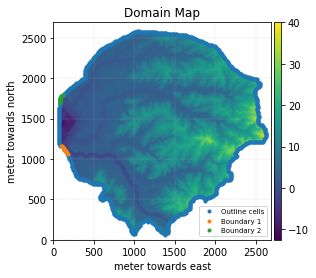

In [11]:
case_input.set_boundary_condition(boundary_list=bound_list)
case_input.domain_show() # show domain map

Great, the boundary conditions are set up correctly! We now need to setup the rainfall mask and rainfall time series.

In [12]:
rain_source_np = rain_source.to_numpy()
case_input.set_rainfall(rain_mask=rain_mask, rain_source=rain_source_np)

We also need to set up the values for the Manning's n. We use a uniform value of 0.03 herein.

In [13]:
manning_array = np.zeros(case_input.DEM.shape)+0.03 # create an array with the same shape of the DEM array
case_input.set_grid_parameter(manning=manning_array)

We want to see the time histories of the depth at the downstream of the main river, so we need to set up a gauging point in the model.

In [14]:
case_input.set_gauges_position(np.array([[127, 1725]]))

The final thing we want to set up is the runtime. We want to run the simulation for 1 hour, get the raster outpurs for every 15 minutes and backup the simulation for every half an hour.

In [14]:
case_input.set_runtime([0, 3600, 900, 1800])

'0-start, 3600-end, 900-output interval, 1800-backup interval'

We have now finished setting up the model. Let's what the model summary tells us.

In [15]:
print(case_input)

---------------------- Model information ---------------------
case_folder : /media/data/lunet/cvxx/hipims_python/tutorials/hipims_case
birthday : 2021-10-26 21:46
num_GPU : 1
run_time : [[0, 3600, 3600, 3600], 's']
num_gauges : 1
---------------------- Grid information ----------------------
area : [4351200.0, 'm^2']
shape : (269, 269)
cellsize : [10.0, 'm']
num_cells : 43512
extent : {'left': 0.0, 'right': 2690.0, 'bottom': 0.0, 'top': 2690.0}
---------------------- Initial condition ---------------------
h0 : 0.0
hU0x : 0
hU0y : 0
---------------------- Boundary condition --------------------
num_boundary : 3
boundary_details : ['0. (outline) fall, h and hU fixed as zero, number of cells: 788', '1. open, hU given, number of cells: 11', '2. open, h given, number of cells: 11']
---------------------- Rainfall ------------------------------
num_source : 4
max : [50.0, 'mm/h']
sum : [12.38, 'mm']
average : [13.75, 'mm/h']
spatial_res : [924.0, 'm']
temporal_res : [360.0, 's']
----------

All seems to be good. We can now write those inputs into files that the flood simulation engine reads.

In [17]:
case_input.write_input_files()

/media/data/lunet/cvxx/hipims_python/tutorials/hipims_case/input/mesh/DEM.txt created
times_setup.dat created
device_setup.dat created
z created
h created
hU created
precipitation created
manning created
sewer_sink created
cumulative_depth created
hydraulic_conductivity created
capillary_head created
water_content_diff created
precipitation_mask created
precipitation_source_all.dat created
boundary condition files created
gauges_pos.dat created


Let's run the model now.

In [19]:
from pypims import flood
flood.run(case_folder)

GPU 0 is choosen as the model device
Current time: 0s
Total time: 3600s
Output time interval: 3600s
Backup interval: 3600s
Read in mesh successfully
Read in field successfully
0
0.005000
Writing backup files
0.302275
3.310217
5.106903
6.615888
8.018401
9.340653
10.626666
11.887608
13.110841
14.314212
15.484290
16.635702
17.773751
18.902482
20.024820
21.142923
22.258326
23.372093
24.484931
25.597290
26.709438
27.774432
28.783892
29.756434
30.703944
31.634686
32.554956
33.470927
34.386695
35.305624
36.229292
37.158410
38.090556
39.023093
39.954236
40.883222
41.809827
42.734073
43.656146
44.576409
45.495617
46.414306
47.332889
48.251930
49.171928
50.093331
51.016540
51.941940
52.869771
53.800132
54.733013
55.664639
56.594471
57.522913
58.450227
59.376560
60.301980
61.226500
62.150087
63.072680
63.994198
64.914546
65.833627
66.751336
67.667562
68.582202
69.495183
70.406458
71.301076
72.180129
73.045446
73.898454
74.740650
75.573269
76.397300
77.213544
78.022670
78.825190
79.621462
80.41172

0

.195955
81.973986
82.747657
83.519243
84.289768
85.059842
85.829875
86.600144
87.370824
88.142007
88.913719
89.685916
90.458542
91.231514
92.004730
92.778075
93.551435
94.324700
95.097770
95.870558
96.642990
97.415007
98.186567
98.957640
99.728210
100.498274
101.267843
102.036936
102.805581
103.573813
104.341670
105.109193
105.876430
106.643425
107.410223
108.176867
108.943400
109.709859
110.476283
111.242703
112.009151
112.775652
113.542227
114.308896
115.075673
115.842567
116.609588
117.376298
118.141552
118.905343
119.667701
120.428677
121.188328
121.946713
122.703889
123.459902
124.214792
124.968589
125.721318
126.473006
127.223679
127.973364
128.722092
129.469899
130.216823
130.962906
131.708189
132.452717
133.196532
133.939671
134.682172
135.424064
136.165376
136.906133
137.646355
138.386063
139.125274
139.864006
140.602273
141.340093
142.077479
142.814446
143.551009
144.287183
145.022981
145.758418
146.493507
147.228260
147.962692
148.696814
149.430637
150.164173
150.897432
151.

## Plot the results

After the simulation finishes, we can plot the depth at the gauge point and the maximum inundation depth over the domain. We need to create an OutputHipims object first.

In [20]:
case_output = IO.OutputHipims(input_obj = case_input)

Then we can read the depth from the outputs.

In [21]:
gauges_pos, times, values = case_output.read_gauges_file(file_tag = 'h')

After reading the output into numpy arrays, we can use matplotlib package to plot the depths.

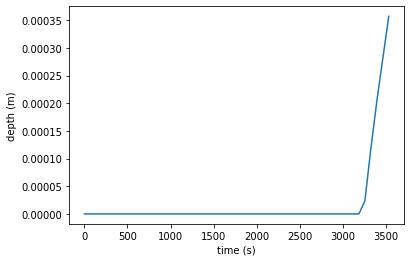

In [22]:
import matplotlib.pyplot as plt
plt.plot(times, values)
plt.xlabel('time (s)')
plt.ylabel('depth (m)')
plt.show()

We can also use the module to read the raster outpus and use mapshow to show the results.

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='meter towards east', ylabel='meter towards north'>)

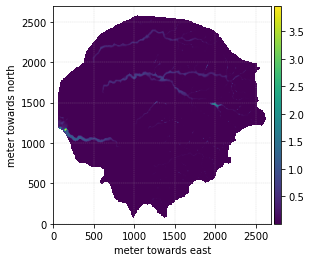

In [23]:
max_depth = case_output.read_grid_file(file_tag='h_max_3600')
IO.grid_show.mapshow(max_depth)

Pypims only provides some basic functions for visualising the outputs. If you need more beautiful plots for your reports or papers. The matplotlib package is a good place to start with. 

Hope you have enjoyed reading this tutorial. Please dive into the API documentation for more advanced usage of pypims.